In [1]:
import matplotlib.pylab as plt
import numpy as np
from astropy import units as u
from astropy.io import fits
import aplpy
import matplotlib.patheffects as pe
from astropy.wcs import WCS

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [87]:
cont = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.image.pbcor.fits')
cont_data = cont[0].data
cont_header = cont[0].header
cont_header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  144                                                  
NAXIS2  =                  144                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   9.387472603056E-04                                                  
BMIN    =   6.558160649406E-04                                                  
BPA     =   3.266278076172E+

In [88]:
rest_frequency = 2.255264159921E+11/1e9*u.GHz
rest_wavelength = rest_frequency.to(u.mm, equivalencies=u.spectral())

print(rest_frequency, rest_wavelength)


225.5264159921 GHz 1.3293008567586224 mm


#### There is a problem in aplpy that does not allow to perform some operations (such as recentering or plotting contours) on 4-dimensional cubes that include the stokes and frequency as additional dimensions. I found a hack that should fix this problem here: https://github.com/aplpy/aplpy/issues/423

In [89]:
def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by aplpy.FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
    temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    temp_wcs = temp_wcs.dropaxis(dropaxis)
    aplpy_obj._wcs = temp_wcs

In [103]:
def figure_layout( fig, c_unit, fontcolor='white', colorbar=True):
    fig.set_nan_color('0.95')
    
    # beam 
    fig.add_beam()
    fig.beam.set(facecolor='white', edgecolor='black', hatch='////////')
    
    # 
    fig.axis_labels.set_font(size=15)
    fig.axis_labels.set_xtext('Right Ascension (ICRS)')
    fig.axis_labels.set_ytext('Declination (ICRS)')
    #fig.axis_labels.set_ypad(pad=-1.5)
    fig.tick_labels.set_yformat('d.ddd')
    fig.tick_labels.set_xformat('d.ddd')

    ## Scale bar
    ang_sep = (12*u.arcsec).to(u.rad)
    fig.add_scalebar(ang_sep)
    fig.scalebar.set_label("$12''$")
    fig.scalebar.set_font(size=22)
    fig.scalebar.set_linewidth(3) 
    fig.scalebar.set_color(fontcolor)
    
    if colorbar:
        fig.add_colorbar()
        fig.colorbar.set_location('right')
        fig.colorbar.set_width(0.1)
        fig.colorbar.set_pad(0.05)
        fig.colorbar.set_axis_label_text(c_unit)
        fig.colorbar.set_label_properties(size=10)
    
    # Ticks
    fig.ticks.set_color(fontcolor)
    fig.ticks.set_tick_direction('in')
    #fig.ticks.set_minor_frequency(4)
    #fig.ticks.set_yspacing(0.006)  # degrees
    

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.580e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.439e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


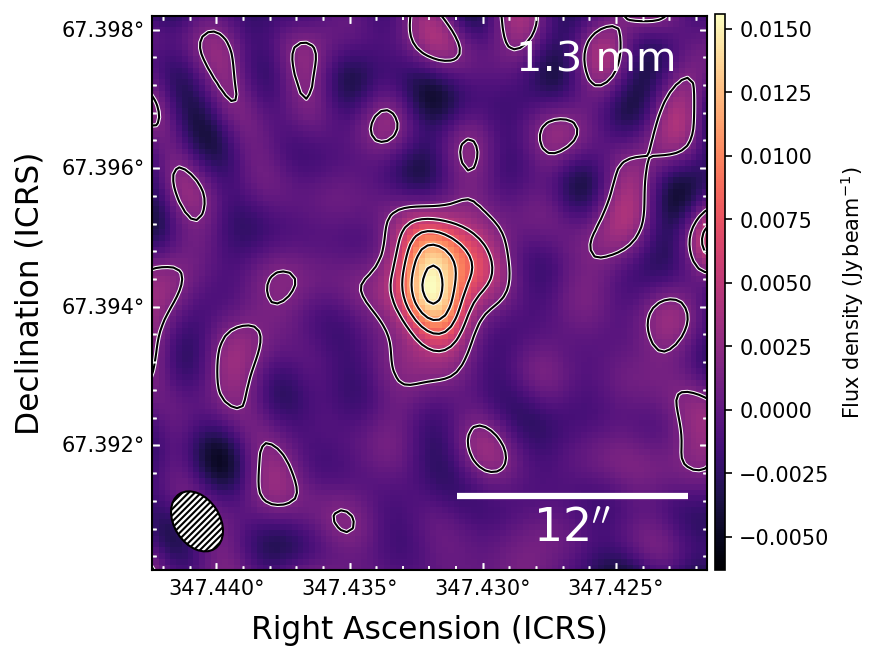

In [104]:
color_table='magma'
fig = plt.figure(dpi=150)

f_cont = aplpy.FITSFigure(cont, figure=fig, dimensions=[0,1], slices=[1])
fix_aplpy_fits(f_cont)

vmin, vmax = np.nanpercentile(cont[0].data, [2,98])
f_cont.show_colorscale(cmap=color_table) 

max_em = 0.016 # Jy/beam from CASA
c_levs = np.arange(0.1,1.2,0.2)*max_em

# adopt the default layout
figure_layout( f_cont, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

f_cont.show_contour(colors='white', linewidths=2., levels=c_levs)
f_cont.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_cont.recenter(347.432,67.3942,width=0.008,height=0.008)

f_cont.add_label(0.8,0.92, '1.3 mm', relative=True, color='white', size=20)


im = plt.imshow(cont[0].data[0][0], cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density $(\mathrm{Jy\,beam^{-1}})$', fontsize=10)

fig.savefig('../plots/DraChi_cont_withcontours.pdf', bbox_inches='tight')

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.724e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.476e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


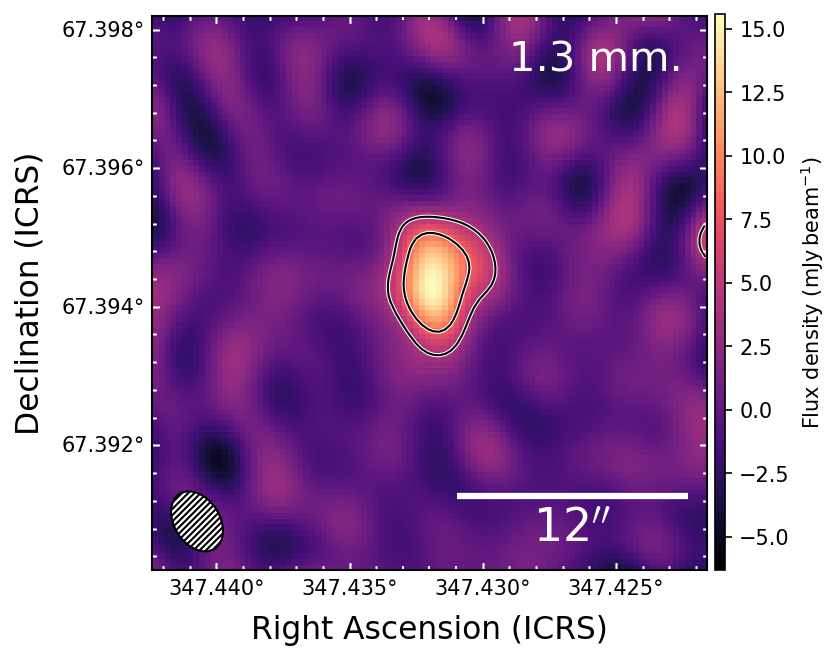

In [136]:
color_table='magma'
fig = plt.figure(dpi=150)

f_cont = aplpy.FITSFigure(cont, figure=fig, dimensions=[0,1], slices=[1])
fix_aplpy_fits(f_cont)

vmin, vmax = np.nanpercentile(cont[0].data, [2,98])
f_cont.show_colorscale(cmap=color_table) 

rms_em = 1.41e-3 # Jy/beam from CASA
c_levs = np.array([3,6,12,24])*rms_em

# adopt the default layout
figure_layout( f_cont, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

f_cont.show_contour(colors='white', linewidths=2., levels=c_levs)
f_cont.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_cont.recenter(347.432,67.3942,width=0.008,height=0.008)

f_cont.add_label(0.80,0.92, '1.3 mm.', relative=True, color='white', size=20)


im = plt.imshow(cont[0].data[0][0]*1000, cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density $(\mathrm{mJy\,beam^{-1}})$', fontsize=10)

fig.savefig('../plots/DraChi_cont_withcontours_2.pdf', bbox_inches='tight')

## Overlay 12CO contours ontop of continuum map

In [106]:
mom0_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.briggs0.12CO.LSRK.im.image_M0.fits')

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.656e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.453e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


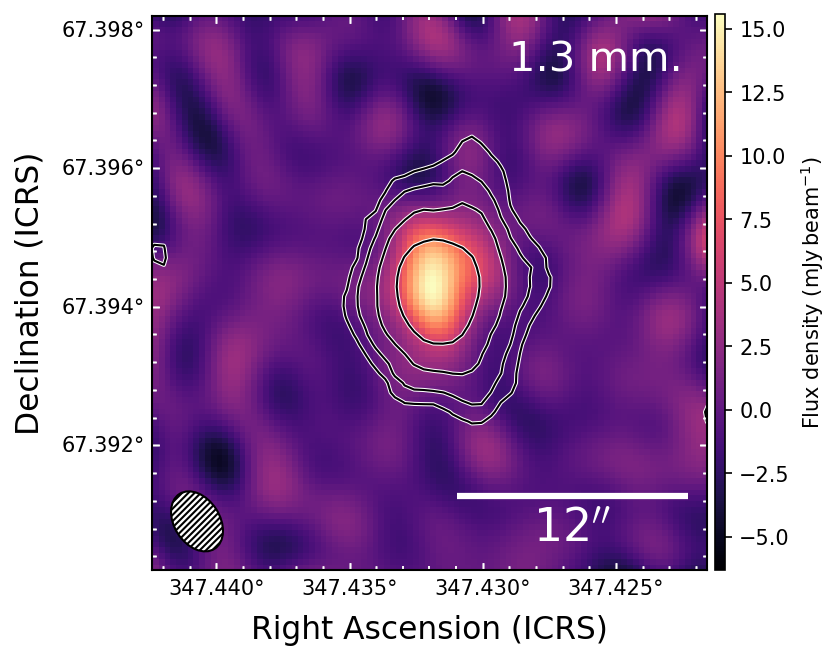

In [112]:
color_table='magma'
fig = plt.figure(dpi=150)

f_cont = aplpy.FITSFigure(cont, figure=fig, dimensions=[0,1], slices=[1])
fix_aplpy_fits(f_cont)

vmin, vmax = np.nanpercentile(cont[0].data, [2,98])
f_cont.show_colorscale(cmap=color_table) 

# adopt the default layout
figure_layout( f_cont, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

rms_em = 2.41e2 # Jy/beam from CASA
c_levs = np.array([3, 6, 12, 24])*rms_em
f_cont.show_contour(mom0_12CO, colors='white', linewidths=2., levels=c_levs)
f_cont.show_contour(mom0_12CO, colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_cont.recenter(347.432,67.3942,width=0.008,height=0.008)

f_cont.add_label(0.80,0.92, '1.3 mm.', relative=True, color='white', size=20)


im = plt.imshow(cont[0].data[0][0]*1000, cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density $(\mathrm{mJy\,beam^{-1}})$', fontsize=10)

fig.savefig('../plots/DraChi_cont_12COcontours.pdf', bbox_inches='tight')

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.572e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.272e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


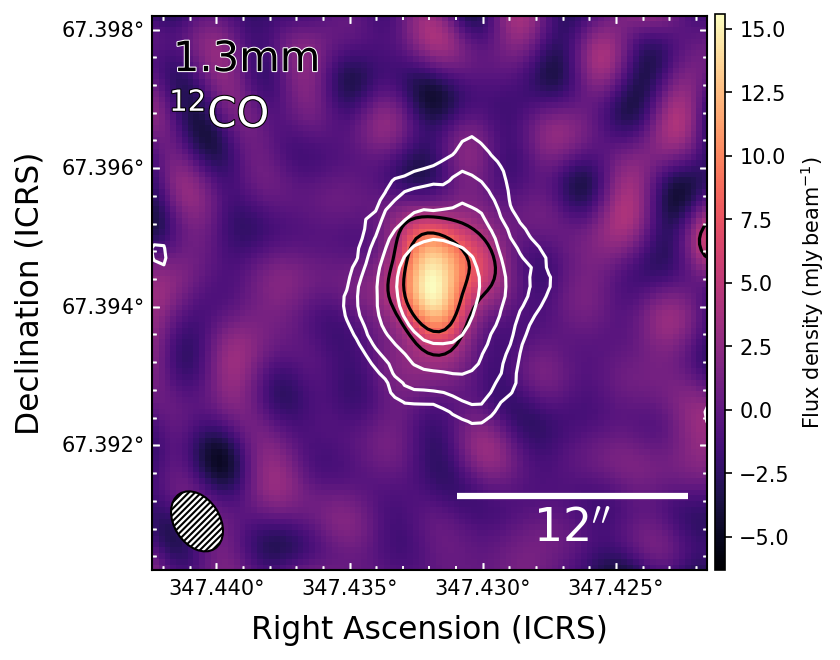

In [135]:
color_table='magma'
fig = plt.figure(dpi=150)

f_cont = aplpy.FITSFigure(cont, figure=fig, dimensions=[0,1], slices=[1])
fix_aplpy_fits(f_cont)

vmin, vmax = np.nanpercentile(cont[0].data, [2,98])
f_cont.show_colorscale(cmap=color_table) 

# adopt the default layout
figure_layout( f_cont, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

rms_em = 1.41e-3 # Jy/beam from CASA
c_levs = np.array([3,6,12,24,48])*rms_em
f_cont.show_contour(colors='black', linewidths=1.5, levels=c_levs)

rms_em = 2.41e2 # Jy/beam from CASA
c_levs = np.array([3,6,12,24,48])*rms_em
f_cont.show_contour(mom0_12CO, colors='white', linewidths=1.5, levels=c_levs)


# got the coordinates of the center from CASAviewer
f_cont.recenter(347.432,67.3942,width=0.008,height=0.008)

f_cont.add_label(0.17,0.92, '1.3mm', relative=True, color='black', size=20, path_effects=[pe.withStroke(linewidth=1., foreground="white")])
f_cont.add_label(0.12,0.82, '$^{12}$CO', relative=True, color='white', size=20, path_effects=[pe.withStroke(linewidth=1., foreground="black")])


im = plt.imshow(cont[0].data[0][0]*1000, cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density $(\mathrm{mJy\,beam^{-1}})$', fontsize=10)

fig.savefig('../plots/DraChi_cont_12COandcontinuumcontours.pdf', bbox_inches='tight')

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.776e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.546e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


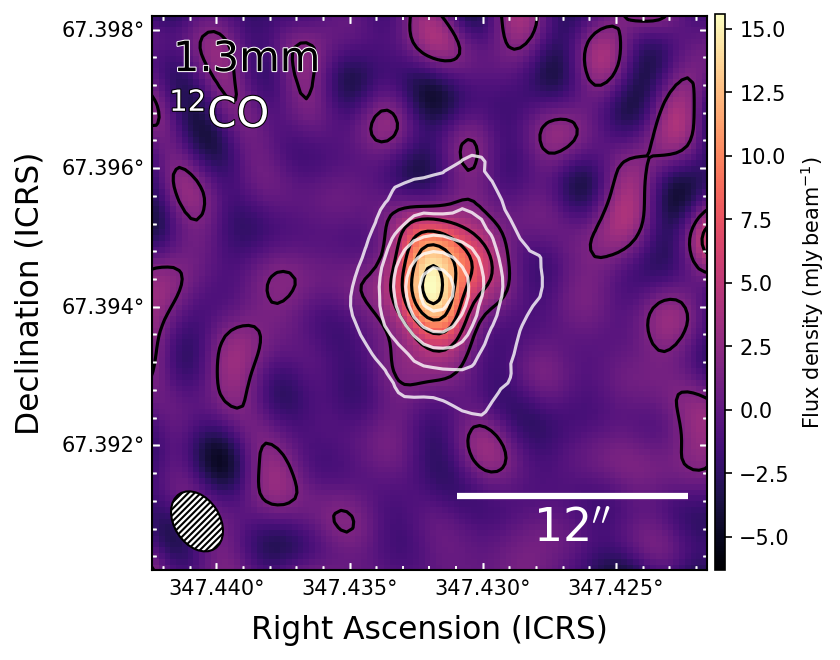

In [139]:
color_table='magma'
fig = plt.figure(dpi=150)

f_cont = aplpy.FITSFigure(cont, figure=fig, dimensions=[0,1], slices=[1])
fix_aplpy_fits(f_cont)

vmin, vmax = np.nanpercentile(cont[0].data, [2,98])
f_cont.show_colorscale(cmap=color_table) 

# adopt the default layout
figure_layout( f_cont, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

max_em = 0.016 # Jy/beam from CASA
c_levs = np.arange(0.1,1.2,0.2)*max_em
f_cont.show_contour(colors='black', linewidths=1.5, levels=c_levs)

max_em = 1.05e4 # mJy/beam m/s from mom0 map
c_levs = np.arange(0.1,1.2,0.2)*max_em
f_cont.show_contour(mom0_12CO, colors='white', linewidths=1.5, levels=c_levs, alpha=0.8)


# got the coordinates of the center from CASAviewer
f_cont.recenter(347.432,67.3942,width=0.008,height=0.008)

f_cont.add_label(0.17,0.92, '1.3mm', relative=True, color='black', size=20, path_effects=[pe.withStroke(linewidth=1., foreground="white")])
f_cont.add_label(0.12,0.82, '$^{12}$CO', relative=True, color='white', size=20, path_effects=[pe.withStroke(linewidth=1., foreground="black")])


im = plt.imshow(cont[0].data[0][0]*1000, cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density $(\mathrm{mJy\,beam^{-1}})$', fontsize=10)

fig.savefig('../plots/DraChi_cont_12COandcontinuumcontours_2.pdf', bbox_inches='tight')